# Nome: Henrique Rodrigues Martins Fontes 
# Matrícula: 14728901

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Preparação dos dados

In [2]:
df = pd.read_csv('C:\\Users\\Henrique\\Desktop\\trabalho IA 2\\dados_filtrados.csv').drop(columns=['Unnamed: 0']) #lê a tabela de dados

Agora que temos nosso conjunto de dados, vamos ver as inforamções dos nossos dados:

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18306 entries, 0 to 18305
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TP_ESCOLA          18306 non-null  int64  
 1   TP_PRESENCA_CH     18306 non-null  int64  
 2   TP_PRESENCA_CN     18306 non-null  int64  
 3   TP_PRESENCA_LC     18306 non-null  int64  
 4   NU_IDADE           18306 non-null  int64  
 5   TP_ST_CONCLUSAO    18306 non-null  int64  
 6   TP_ANO_CONCLUIU    18306 non-null  int64  
 7   TP_ENSINO          5762 non-null   float64
 8   IN_TREINEIRO       18306 non-null  int64  
 9   NU_NOTA_CN         13783 non-null  float64
 10  NU_NOTA_CH         13783 non-null  float64
 11  NU_NOTA_LC         13510 non-null  float64
 12  NU_NOTA_MT         10133 non-null  float64
 13  TP_STATUS_REDACAO  13510 non-null  float64
 14  NU_NOTA_REDACAO    13510 non-null  float64
dtypes: float64(7), int64(8)
memory usage: 2.1 MB
None


Podemos ver que há alguns dados faltantes. Vamos verificar onde:

In [4]:
print(df.isna().sum())

TP_ESCOLA                0
TP_PRESENCA_CH           0
TP_PRESENCA_CN           0
TP_PRESENCA_LC           0
NU_IDADE                 0
TP_ST_CONCLUSAO          0
TP_ANO_CONCLUIU          0
TP_ENSINO            12544
IN_TREINEIRO             0
NU_NOTA_CN            4523
NU_NOTA_CH            4523
NU_NOTA_LC            4796
NU_NOTA_MT            8173
TP_STATUS_REDACAO     4796
NU_NOTA_REDACAO       4796
dtype: int64


Como podemos ver abaixo, se utilizarmos somente as linhas sem dados faltantes, perderemos muitos dados, ou seja, não é viável descartar esses dados.

In [5]:
df_clean = df.dropna(axis = 0, how = 'any', inplace = False)
print(len(df_clean), 'linhas restantes de um total de', len(df), 'linhas')
print(100*len(df_clean)/len(df),'%')

3628 linhas restantes de um total de 18306 linhas
19.818638697694745 %


Algumas dessas variáveis são complicadas de impor um dado valor e além disso, impor um valor pode influenciar na correlação com a variável alvo. Portanto, primeiro irei verificar a correlação com os dados puros.

In [6]:
correlacoes = df.corr()
correlacoes['NU_NOTA_MT']

TP_ESCOLA            0.069304
TP_PRESENCA_CH       0.003552
TP_PRESENCA_CN       0.003552
TP_PRESENCA_LC            NaN
NU_IDADE            -0.061485
TP_ST_CONCLUSAO     -0.087869
TP_ANO_CONCLUIU      0.029039
TP_ENSINO           -0.086353
IN_TREINEIRO        -0.022287
NU_NOTA_CN           0.584941
NU_NOTA_CH           0.529594
NU_NOTA_LC           0.494695
NU_NOTA_MT           1.000000
TP_STATUS_REDACAO   -0.059376
NU_NOTA_REDACAO      0.379376
Name: NU_NOTA_MT, dtype: float64

Para filtrar quais variáveis vou selecionar, irei determinar um corte na correlação de |correlaçao| >=  0.3

In [7]:
variaveis = correlacoes[(correlacoes['NU_NOTA_MT'] <= -0.3) | (correlacoes['NU_NOTA_MT'] >= 0.3) & (correlacoes['NU_NOTA_MT'] < 1.0)]['NU_NOTA_MT']
variaveis

NU_NOTA_CN         0.584941
NU_NOTA_CH         0.529594
NU_NOTA_LC         0.494695
NU_NOTA_REDACAO    0.379376
Name: NU_NOTA_MT, dtype: float64

vamos vizualizar a correlação entre as variáveis selecionadas

<Axes: >

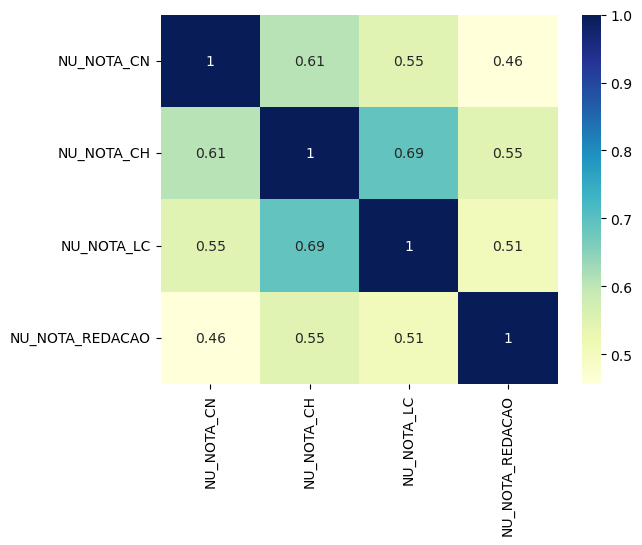

In [8]:
lista_variaveis = variaveis.index.to_list() #Nome das variáveis numa lista
corr = df[lista_variaveis].corr() #DataFrame das correlações
sns.heatmap(corr,  annot=True, annot_kws={"size": 10},cmap="YlGnBu")

Agora, dentro dessas variáveis selecionadas, temos diversos valores faltantes:

In [9]:
lista_variaveis_mt = lista_variaveis[:]
lista_variaveis_mt.insert(4,'NU_NOTA_MT')
df_novo= df[lista_variaveis_mt] #tabela de dados apenas com as variáveis selecionadas

In [10]:
df_novo.isna().sum()

NU_NOTA_CN         4523
NU_NOTA_CH         4523
NU_NOTA_LC         4796
NU_NOTA_REDACAO    4796
NU_NOTA_MT         8173
dtype: int64

Esses valores faltantes podem estar relacionados ao aluno não ter ido no dia da prova. Vamos verificar isso: 

No Enem de 2016, no primeiro dia, caiu ciências humanas e ciências da natureza. Já no segundo dia caiu linguagens e códigos, redação e matemática. Com isto iremos verificar as notas dessas provas com base na presença nas provas de ciências da natureza (TP_PRESENCA_CN) e linguagens e códigos (TP_PRESENCA_LC) e ciências humanas (TP_PRESENCA_CH).

In [11]:
lista_TP__PRESENCA = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC'] 
valor_TP__PRESENCA = [0,1,2]
lista_NU_NOTA = ['NU_NOTA_CN','NU_NOTA_CH', 'NU_NOTA_LC','NU_NOTA_REDACAO','NU_NOTA_MT']

for i in lista_TP__PRESENCA:
    for k in lista_NU_NOTA:
        if k == 'NU_NOTA_LC':
            print('')
        elif k == 'NU_NOTA_REDACAO':
            print('')
        elif k == 'NU_NOTA_MT':
            print('')
        for j in valor_TP__PRESENCA:
            if i == 'TP_PRESENCA_CN':
                if k == 'NU_NOTA_CN':
                    valores = df.loc[df[i] == j, k]
                    qnt_diff = len(valores[valores.notna()])
                    qnt_igual = len(valores[valores.isna()])
                    print('quantidade de valores diferentes de NaN na coluna',k,'quando', i,' = ',j,' --> ', qnt_diff,'( total de NaNs =',qnt_igual,')')
            if i == 'TP_PRESENCA_CH':
                 if k == 'NU_NOTA_CH':
                    valores = df.loc[df[i] == j, k]
                    qnt_diff = len(valores[valores.notna()])
                    qnt_igual = len(valores[valores.isna()])
                    print('quantidade de valores diferentes de NaN na coluna',k,'quando', i,' = ',j,' --> ', qnt_diff,'( total de NaNs =',qnt_igual,')')
            if i == 'TP_PRESENCA_LC':
                if k == 'NU_NOTA_LC':
                    valores = df.loc[df[i] == j, k]
                    qnt_diff = len(valores[valores.notna()])
                    qnt_igual = len(valores[valores.isna()])
                    print('quantidade de valores diferentes de NaN na coluna',k,'quando', i,' = ',j,' --> ', qnt_diff,'( total de NaNs =',qnt_igual,')') 
                if k == 'NU_NOTA_REDACAO':
                    valores = df.loc[df[i] == j, k]
                    qnt_diff = len(valores[valores.notna()])
                    qnt_igual = len(valores[valores.isna()])
                    print('quantidade de valores diferentes de NaN na coluna',k,'quando', i,' = ',j,' --> ', qnt_diff,'( total de NaNs =',qnt_igual,')')
                if k == 'NU_NOTA_MT':
                    valores = df.loc[df[i] == j, k]
                    qnt_diff = len(valores[valores.notna()])
                    qnt_igual = len(valores[valores.isna()])
                    print('quantidade de valores diferentes de NaN na coluna',k,'quando', i,' = ',j,' --> ', qnt_diff,'( total de NaNs =',qnt_igual,')')

quantidade de valores diferentes de NaN na coluna NU_NOTA_CN quando TP_PRESENCA_CN  =  0  -->  0 ( total de NaNs = 4514 )
quantidade de valores diferentes de NaN na coluna NU_NOTA_CN quando TP_PRESENCA_CN  =  1  -->  13783 ( total de NaNs = 0 )
quantidade de valores diferentes de NaN na coluna NU_NOTA_CN quando TP_PRESENCA_CN  =  2  -->  0 ( total de NaNs = 9 )



quantidade de valores diferentes de NaN na coluna NU_NOTA_CH quando TP_PRESENCA_CH  =  0  -->  0 ( total de NaNs = 4514 )
quantidade de valores diferentes de NaN na coluna NU_NOTA_CH quando TP_PRESENCA_CH  =  1  -->  13783 ( total de NaNs = 0 )
quantidade de valores diferentes de NaN na coluna NU_NOTA_CH quando TP_PRESENCA_CH  =  2  -->  0 ( total de NaNs = 9 )




quantidade de valores diferentes de NaN na coluna NU_NOTA_LC quando TP_PRESENCA_LC  =  0  -->  0 ( total de NaNs = 4787 )
quantidade de valores diferentes de NaN na coluna NU_NOTA_LC quando TP_PRESENCA_LC  =  1  -->  13510 ( total de NaNs = 0 )
quantidade de valore

Como podemos ver, todos os valores de notas faltantes correspondem aos dias que os alunos não foram fazer a prova e/ou foram eliminados. Contudo, algumas notas de matématica são faltantes mesmo no dia que os alunos foram fazer a prova. 

Para substituir os valores faltantes, vou optar por colocar zero nos valores faltantes que correspondem aos dias que os alunos faltaram e/ou foram eliminados, mas para os valores faltantes que correspondem aos dias que os alunos foram fazer a prova colocarei a média.

In [12]:
df_novo['NU_NOTA_CN'] = df_novo['NU_NOTA_CN'].fillna(0) # preenche com zero os valores faltantes na coluna NU_NOTA_CN
df_novo['NU_NOTA_CH'] = df_novo['NU_NOTA_CH'].fillna(0) # preenche com zero os valores faltantes na coluna NU_NOTA_CH
df_novo['NU_NOTA_LC'] = df_novo['NU_NOTA_LC'].fillna(0) # preenche com zero os valores faltantes na coluna NU_NOTA_LC
df_novo['NU_NOTA_REDACAO'] =df_novo['NU_NOTA_REDACAO'].fillna(0) # preenche com zero os valores faltantesna coluna NU_NOTA_REDACAO
df_novo.loc[df['TP_PRESENCA_LC'] == 1, 'NU_NOTA_MT'] = df_novo.loc[df['TP_PRESENCA_LC'] == 1, 'NU_NOTA_MT'].fillna(df_novo['NU_NOTA_MT'].mean()) # preenche com zero os valores faltantes na coluna NU_NOTA_MT que estão 
# na mesma linha dos valores 1 na coluna TP_PRESENCA_LC
df_novo['NU_NOTA_MT'] = df_novo['NU_NOTA_MT'].fillna(0) # preenche com zero os valores faltantes restantes na coluna NU_NOTA_MT

In [13]:
df_novo.isna().sum()

NU_NOTA_CN         0
NU_NOTA_CH         0
NU_NOTA_LC         0
NU_NOTA_REDACAO    0
NU_NOTA_MT         0
dtype: int64

Agora, iremos pegar os dados e separar entre variáveis preditoras e variável alvo. As variáveis não precisam ser reescalonadas pois os modelos não apresentaram mudanças relevantes para adotar isso.

In [14]:
X = df_novo.drop(['NU_NOTA_MT'], axis=1)
y = df_novo.NU_NOTA_MT

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1 - regressão multilinear

O primeiro modelo que irei utilizar é o de regressão multilinear, isto é, irei utilizar todos os preditores selecionados.

Para verificar as métricas de qualidade do ajuste, irei utilizar o pacote stasmodels. 

In [15]:
X_trainsm = sm.add_constant(X_train) # adicionar uma coluna constante para o statsmodels ajustar um itercepto
X_testsm = sm.add_constant(X_test)
def predicao_ML(X, Y, X_pred, metodo):
    if metodo == 'OLS':
        mod = sm.OLS(Y, X)
    elif metodo == 'WLS':
        mod = sm.WLS(Y, X)
    else: 
        print("Adicionar método na função predicao_ML. Métodos contemplados 'OLS' e 'WLS'.")

    regsm = mod.fit()
    y_pred = regsm.predict(X_pred)
    return y_pred, regsm

# 1.1 -  método OLS Regression

### 1.1.1 - métricas de desempenho:

In [16]:
y_pred_train_OLS, fit = predicao_ML(X_trainsm, y_train, X_trainsm, 'OLS')
y_pred_test_OLS, fit = predicao_ML(X_trainsm, y_train, X_testsm, 'OLS')
# print(fit.summary())

type(y_pred_test_OLS)

pandas.core.series.Series

### 1.1.2 - Desempenho

In [17]:
def metrica(y_train,y_pred_train,y_test,y_pred_test):

    scaler = StandardScaler()
    y_train_reescalonado = scaler.fit_transform(y_train.values.reshape(-1,1))
    y_train_reescalonado = pd.Series(y_train_reescalonado.flatten())
    
    y_test_reescalonado = scaler.fit_transform(y_test.values.reshape(-1,1))
    y_test_reescalonado = pd.Series(y_test_reescalonado.flatten())

    y_pred_train_reescalonado = scaler.fit_transform(y_pred_train.values.reshape(-1,1))
    y_pred_train_reescalonado = pd.Series(y_pred_train_reescalonado.flatten())
    
    y_pred_test_reescalonado = scaler.fit_transform(y_pred_test.values.reshape(-1,1))
    y_pred_test_reescalonado = pd.Series(y_pred_test_reescalonado.flatten())
    
    r2_train = r2_score(y_train_reescalonado,  y_pred_train_reescalonado)
    MSE_train  = mean_squared_error(y_train_reescalonado,  y_pred_train_reescalonado)
    MAE_train  = mean_absolute_error(y_train_reescalonado, y_pred_train_reescalonado)   


    r2_test = r2_score(y_test_reescalonado, y_pred_test_reescalonado)
    MSE_test = mean_squared_error(y_test_reescalonado,y_pred_test_reescalonado)
    MAE_test = mean_absolute_error(y_test_reescalonado, y_pred_test_reescalonado)

    
    list_conjunto = ['Desempenho no Conjunto de Treinamento','Desempenho no Conjunto de Teste'] 
    list_r2 = [r2_train,r2_test]
    list_MSE = [MSE_train,MSE_test]
    list_MAE = [MAE_train,MAE_test]
    
    return list_conjunto, list_r2, list_MSE, list_MAE

In [18]:
def tabela_metrica(list_conjunto, list_r2, list_MSE, list_MAE):
    header = "|{:^40s}|{:^10s}|{:^10s}|{:^10s}|".format(
        "","R²", "MSE", "MAE"
    )
    
    line = "-" * len(header)
    print("Métrica de desempenho regressão multilinear:")
    print(line)
    print(header)
    print(line)

    data = zip(list_conjunto, list_r2, list_MSE, list_MAE)

    
    
    for i, row in enumerate(data):
        print("|{:^40s}|{:^10.3f}|{:^10.3f}|{:^10.3f}|".format(*row,))
        print(line)

In [19]:
tabela_metrica(metrica(y_train,y_pred_train_OLS,y_test,y_pred_test_OLS)[0],metrica(y_train,y_pred_train_OLS,y_test,y_pred_test_OLS)[1],metrica(y_train,y_pred_train_OLS,y_test,y_pred_test_OLS)[2],metrica(y_train,y_pred_train_OLS,y_test,y_pred_test_OLS)[3])

Métrica de desempenho regressão multilinear:
---------------------------------------------------------------------------
|                                        |    R²    |   MSE    |   MAE    |
---------------------------------------------------------------------------
| Desempenho no Conjunto de Treinamento  |  0.905   |  0.095   |  0.227   |
---------------------------------------------------------------------------
|    Desempenho no Conjunto de Teste     |  0.914   |  0.086   |  0.216   |
---------------------------------------------------------------------------


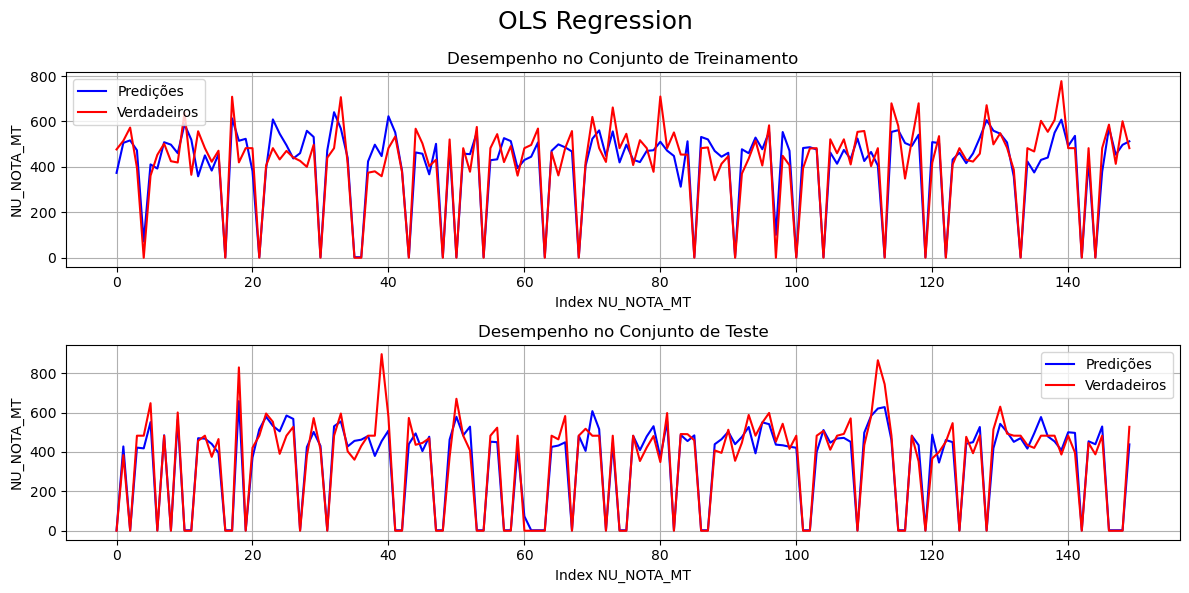

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

axs[0].plot(y_pred_train_OLS.tolist()[:150], color='blue', label='Predições')
axs[0].plot(y_train.tolist()[:150], color='red', label='Verdadeiros')
axs[0].set_title('Desempenho no Conjunto de Treinamento')
axs[0].set_ylabel('NU_NOTA_MT')
axs[0].set_xlabel('Index NU_NOTA_MT')
axs[0].legend()
axs[0].grid(True)

# Plotar desempenho no conjunto de teste
axs[1].plot(y_pred_test_OLS.tolist()[:150], color='blue', label='Predições')
axs[1].plot(y_test.tolist()[:150], color='red', label='Verdadeiros')
axs[1].set_title('Desempenho no Conjunto de Teste')
axs[1].set_ylabel('NU_NOTA_MT')
axs[1].set_xlabel('Index NU_NOTA_MT')
axs[1].legend()
axs[1].grid(True)

fig.suptitle('OLS Regression', size=18)

# Exibir os subplots
plt.tight_layout()
plt.show()

Como podemos ver, neste método de regressão linear, a predição dos valores é bastante razoável e aparenta generalizar bem quando olhamos para as métricas do conjunto teste.

# 1.2 -  método WLS Regression

### 1.2.1 - métricas de desempenho:

In [21]:
y_pred_train_WLS, fit = predicao_ML(X_trainsm, y_train, X_trainsm, 'WLS')
y_pred_test_WLS, fit = predicao_ML(X_trainsm, y_train, X_testsm, 'WLS')
print(fit.summary())

                            WLS Regression Results                            
Dep. Variable:             NU_NOTA_MT   R-squared:                       0.908
Model:                            WLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                 3.596e+04
Date:                Wed, 22 May 2024   Prob (F-statistic):               0.00
Time:                        20:46:16   Log-Likelihood:                -82623.
No. Observations:               14644   AIC:                         1.653e+05
Df Residuals:                   14639   BIC:                         1.653e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.4697      1.116     

### 1.2.2 - Desempenho

In [22]:
tabela_metrica(metrica(y_train,y_pred_train_WLS,y_test,y_pred_test_WLS)[0],metrica(y_train,y_pred_train_WLS,y_test,y_pred_test_WLS)[1],metrica(y_train,y_pred_train_WLS,y_test,y_pred_test_WLS)[2],metrica(y_train,y_pred_train_WLS,y_test,y_pred_test_WLS)[3])

Métrica de desempenho regressão multilinear:
---------------------------------------------------------------------------
|                                        |    R²    |   MSE    |   MAE    |
---------------------------------------------------------------------------
| Desempenho no Conjunto de Treinamento  |  0.905   |  0.095   |  0.227   |
---------------------------------------------------------------------------
|    Desempenho no Conjunto de Teste     |  0.914   |  0.086   |  0.216   |
---------------------------------------------------------------------------


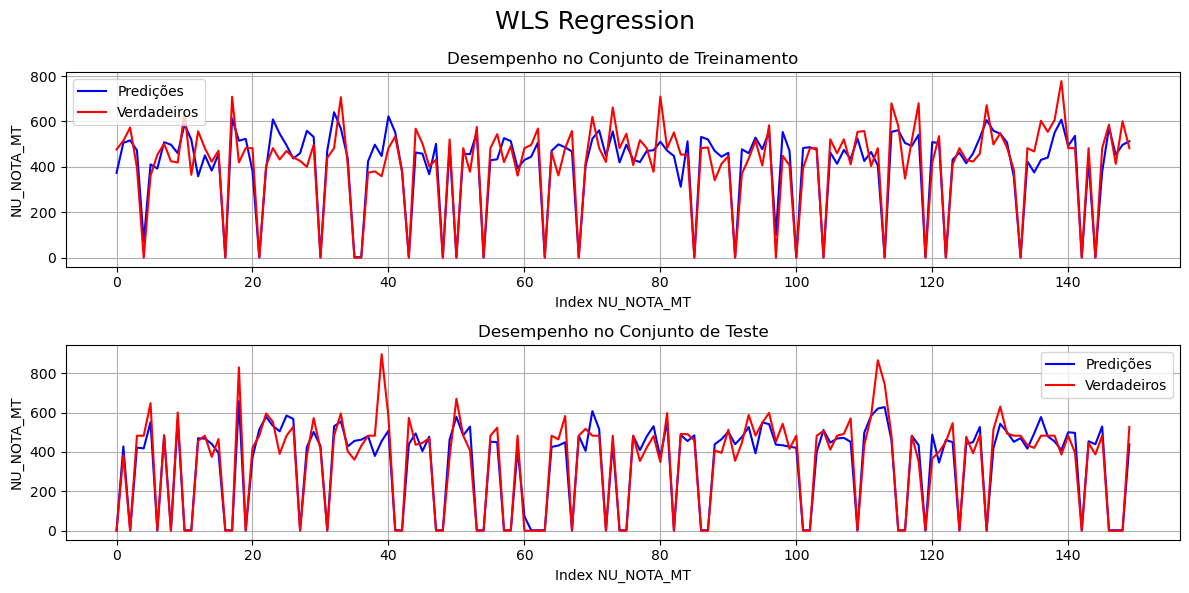

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

axs[0].plot(y_pred_train_WLS.tolist()[:150], color='blue', label='Predições')
axs[0].plot(y_train.tolist()[:150], color='red', label='Verdadeiros')
axs[0].set_title('Desempenho no Conjunto de Treinamento')
axs[0].set_ylabel('NU_NOTA_MT')
axs[0].set_xlabel('Index NU_NOTA_MT')
axs[0].legend()
axs[0].grid(True)

# Plotar desempenho no conjunto de teste
axs[1].plot(y_pred_test_WLS.tolist()[:150], color='blue', label='Predições')
axs[1].plot(y_test.tolist()[:150], color='red', label='Verdadeiros')
axs[1].set_title('Desempenho no Conjunto de Teste')
axs[1].set_ylabel('NU_NOTA_MT')
axs[1].set_xlabel('Index NU_NOTA_MT')
axs[1].legend()
axs[1].grid(True)

fig.suptitle('WLS Regression', size=18)

# Exibir os subplots
plt.tight_layout()
plt.show()

Como podemos ver, para o método WLS as coisas não mudam em relação ao OLS. Ambos os métodos descrevem bem tanto o conjunto de treino quanto o de teste.

# 2 - Random Forest Regressor

Agora iremos utilizar o método do Random Forest Regressor. A primeira coisa que farei será otimizar as escolhas dos hiperparâmetros usando o RandomizedSearchCV.

In [24]:
RFR = RandomForestRegressor()

params = {
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'], # hiperparâmetro a serem testados
    'max_depth': list(range(1, 20)),
    'max_features': list(range(1, 20)),
    'min_samples_split': np.arange(0.001, 1, 0.001), 
    'min_samples_leaf': np.arange(0.0001, 0.5, 0.001) 
}

gs_tree = RandomizedSearchCV(estimator=RFR,
                             param_distributions=params,
                             scoring='r2', # Métrica de avaliação
                             cv=5, # Número de folds na validação cruzada
                             n_iter=1000, # Número de iterações para a busca aleatória
                             random_state=42, # Para reprodutibilidade dos resultados
                             n_jobs=-1) # Utilizar todos os núcleos disponíveis

gs_tree.fit(X_train, y_train) # fita o conunto ao modelo para todas as ombinações de hiperparâmet

print('Melhores hiperparâmetros:')
print(gs_tree.best_params_)
print('Melhor score:')
print(gs_tree.best_score_)

Melhores hiperparâmetros:
{'min_samples_split': 0.074, 'min_samples_leaf': 0.022099999999999998, 'max_features': 10, 'max_depth': 16, 'criterion': 'friedman_mse'}
Melhor score:
0.9236097927470468


Em seguida, irei aplicar os melhores hiperparâmetros no modelo

In [25]:
melhor_RFR =  RandomForestRegressor(**gs_tree.best_params_) # aplica o RandomForestRegressor com os melhores hiperparâmetros
regRFR = melhor_RFR.fit(X_train, y_train) # fita o conjunto de treino ao modelo
y_pred_test_RFR = pd.Series(regRFR.predict(X_test)) # y previsto para o conjunto de teste
y_pred_train_RFR = pd.Series(regRFR.predict(X_train)) # y previsto para o conjunto de treino

### 2.1 Desempenho

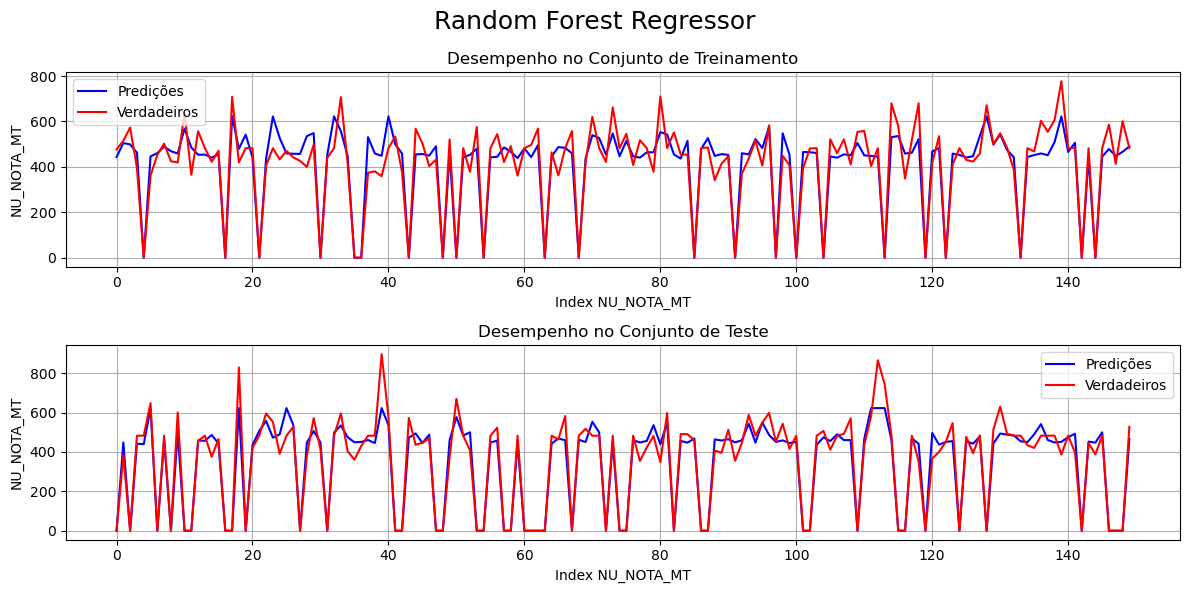

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

axs[0].plot(y_pred_train_RFR.tolist()[:150], color='blue', label='Predições')
axs[0].plot(y_train.tolist()[:150], color='red', label='Verdadeiros')
axs[0].set_title('Desempenho no Conjunto de Treinamento')
axs[0].set_ylabel('NU_NOTA_MT')
axs[0].set_xlabel('Index NU_NOTA_MT')
axs[0].legend()
axs[0].grid(True)

# Plotar desempenho no conjunto de teste
axs[1].plot(y_pred_test_RFR.tolist()[:150], color='blue', label='Predições')
axs[1].plot(y_test.tolist()[:150], color='red', label='Verdadeiros')
axs[1].set_title('Desempenho no Conjunto de Teste')
axs[1].set_ylabel('NU_NOTA_MT')
axs[1].set_xlabel('Index NU_NOTA_MT')
axs[1].legend()
axs[1].grid(True)

fig.suptitle('Random Forest Regressor', size=18)

# Exibir os subplots
plt.tight_layout()
plt.show()

In [27]:
tabela_metrica(metrica(y_train,y_pred_train_RFR,y_test,y_pred_test_RFR)[0],metrica(y_train,y_pred_train_RFR,y_test,y_pred_test_RFR)[1],metrica(y_train,y_pred_train_RFR,y_test,y_pred_test_RFR)[2],metrica(y_train,y_pred_train_RFR,y_test,y_pred_test_RFR)[3])

Métrica de desempenho regressão multilinear:
---------------------------------------------------------------------------
|                                        |    R²    |   MSE    |   MAE    |
---------------------------------------------------------------------------
| Desempenho no Conjunto de Treinamento  |  0.923   |  0.077   |  0.200   |
---------------------------------------------------------------------------
|    Desempenho no Conjunto de Teste     |  0.931   |  0.069   |  0.190   |
---------------------------------------------------------------------------


Como podemos ver, o método do Random Forest Regressor, usando os melhores hiperparâmetros, descreveram bem os dados verdadeiros, com uma qualidade superior ao método de regressão multilinear. Olhando para os valores das métricas de desempenho, podemos ver que o modelo generaliza bem para o conjunto 

# Conclusão

Fazendo o tratamento de dados que fiz, impondo o valor zero para as notas faltantes que correspondiam aos dias que os alunos faltaram e foram eliminados da prova e colocando a média nas notas faltantes que correspondiam aos dias que os alunos foram fazer a prova, no geral, os modelos realizaram uma boa previsão para a variável alvo. Quando olhamos paras os resultados no conjunto de teste, os modelos parecem conseguir generalizar satisfatóriamente.